In [1]:
import pymc as pm
import pandas as pd
import numpy as np

import pyei as pyei
import matplotlib as mpl
import matplotlib.pyplot as plt
#from pymc import sampling_jax
import arviz as az
import seaborn as sns

from scipy import stats

import sys
sys.path.append('..')

/home/annahaensch/anaconda3/envs/my_env/lib/python3.11/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/home/annahaensch/anaconda3/envs/my_env/lib/python3.11/site-packages/pyei/distribution_utils.py:16: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/annahaensch/anaconda3/envs/my_env/lib/python3.11/site-packages/pyei/distribution_utils.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.

In [2]:
pm.__version__

'4.0.0b5'

In [5]:
# Example 2x2 data
data = pd.read_csv("../data/demographics_with_race.csv", index_col = 0)
data

,pop,race_w,race_b,hhinc,incpercap,incpov_2_,incpov__2,init_count_pre,init_day_pre,tot_count_pre,tot_day_pre,init_p_pre,init_count_covid,init_day_covid,tot_count_covid,tot_day_covid,init_p_covid
0,478,97.07,0.00,83667,73312,90.17,9.83,2815,7.019950,3889,9.698254,72.383646,482,2.190909,945,4.295455,51.005291
1,1212,85.23,4.04,77604,42620,77.56,22.44,2161,5.389027,3192,7.960100,67.700501,782,3.554545,1373,6.240909,56.955572
2,2109,71.12,7.02,105913,21587,89.16,10.84,1524,3.800499,1932,4.817955,78.881988,63,0.286364,231,1.050000,27.272727
3,676,83.14,0.00,66944,35319,68.20,31.80,174,0.433915,380,0.947631,45.789474,14,0.063636,79,0.359091,17.721519
4,1137,64.56,9.59,55167,14173,65.80,34.20,555,1.384040,961,2.396509,57.752341,12,0.054545,207,0.940909,5.797101
5,1044,81.80,4.69,116875,43521,82.38,17.62,1285,3.204489,1861,4.640898,69.048898,355,1.613636,628,2.854545,56.528662
6,858,92.66,2.45,81875,39540,85.05,14.95,2149,5.359102,2880,7.182045,74.618056,830,3.772727,1206,5.481818,68.822554


In [6]:
# Proportion of white residents by CBG.
X_race = np.array((data["race_w"]/100))
X_race

# Number of white residents by CBG.
num_white = X_race * data["pop"].values
num_white

# Proportion of non-white residents by CBG.
1-X_race

# Number of non-white residents by CBG.
num_non_white = (1-X_race)*data["pop"].values
num_non_white

# Number of calls by CBG
C = (np.array(data["tot_count_pre"]) - np.array(data["init_count_pre"])) 
C

# Number of people by CBG
p = data["pop"].values
p

array([ 478, 1212, 2109,  676, 1137, 1044,  858])

In [7]:
# Proportion of non low income residents by CBG.
X_pov = 1 - np.array((data["incpov__2"]/100))

# Number of non-low income residents by CBG.
num_non_low_inc = X_pov*data["pop"].values.round()
num_non_low_inc

# Number of non low-income residents by CBG.
num_low_inc = p - num_non_low_inc


In [8]:
C/p

array([2.24686192, 0.85066007, 0.19345661, 0.30473373, 0.35708004,
       0.55172414, 0.85198135])

In [9]:
C

array([1074, 1031,  408,  206,  406,  576,  731])

## Set up and fit the model

In [ ]:
num_precincts = len(p)
def fit_model2(num_gp1, num_gp2, C):
    num_precincts = len(C)
    with pm.Model(rng_seeder=42) as model:

        mu_1 =    pm.HalfCauchy("mu_1", 1)
        mu_2 =    pm.HalfCauchy("mu_2", 1) 
       
        sigma_1 = pm.Gamma("sigma_1", mu=4, sigma = 8 ** 0.5)
        sigma_2 = pm.Gamma("sigma_2", mu=4, sigma = 8 ** 0.5)

        b_1 = pm.TruncatedNormal("b_1", mu=mu_1, sigma=sigma_1, lower=0, shape=num_precincts)
        b_2 = pm.TruncatedNormal("b_2", mu=mu_2, sigma=sigma_2, lower=0, shape=num_precincts)

        theta = num_gp1 * b_1 + num_gp2 * b_2

        pm.Poisson("calls_for_service", mu=theta, observed=C)

        sim_trace = pm.sample(
            draws=2000,
            chains=4,
            tune=2000,
            target_accept = .995,
            random_seed=42
            )
         # sim_trace = sampling_jax.sample_numpyro_nuts(
        #                         #target_accept=target_accept,
        #                         #tune=tune,
        #                         #**other_sampling_args,
        #                     )

        
        return sim_trace, model

sim_trace_model2, model2 = fit_model2(num_white, num_non_white, C)
sim_trace_model2_inc, model_inc = fit_model2(num_low_inc, num_non_low_inc, C)

   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/annahaensch/anaconda3/envs/my_env/lib/python3.11/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, mu_2, sigma_1, sigma_2, b_1, b_2]


## Inspect traces, visualize some priors

In [ ]:

az.plot_trace(sim_trace_model2)

## Prior predictive checks

In [ ]:
# visualize hyperpriors
sigma_test = np.linspace(0.1,5,100)
m_1 = 4
s_1 = 8 ** 0.5
sigma_1 = pm.Gamma.dist(mu=m_1, sigma=s_1)
sigma_logp = pm.logp(sigma_1, sigma_test).eval()

fig, axes = plt.subplots(1, 4, figsize=(12,3))
axes[0].plot(sigma_test, np.exp(sigma_logp))
axes[0].set_title(r"prior for $\sigma_g, \sigma_0$")

mu_test = np.linspace(0.1, 4, 100)
mu_1 = pm.HalfCauchy.dist(1)
mu_1_logp = pm.logp(mu_1, mu_test).eval()
axes[1].plot(mu_test, np.exp(mu_1_logp))
axes[1].set_title(r"prior for $\mu_g, \mu_0$")

mu_1 = 2
sigma_1 = 2
b_1 = pm.Gamma.dist(mu=mu_1, sigma=sigma_1)
b_1_logp = pm.logp(b_1, mu_test).eval()
axes[2].plot(mu_test, np.exp(b_1_logp))
axes[2].set_title(fr"$r_0$ | $\mu_0$={mu_1}, $\sigma_0$={sigma_1}")

mu_1 = 1
sigma_1 = 3
b_1 = pm.Gamma.dist(mu=mu_1, sigma=sigma_1)
b_1_logp = pm.logp(b_1, mu_test).eval()
axes[3].plot(mu_test, np.exp(b_1_logp))
axes[3].set_title(fr"$r_1$ | $\mu_0$={mu_1}, $\sigma_0$={sigma_1}")
plt.show()

In [ ]:
with model2:
    prior_predictive = pm.sample_prior_predictive(samples=500, random_seed=42)
with model_inc:
    prior_predictive_inc = pm.sample_prior_predictive(samples=500, random_seed=42)


In [ ]:
mpl.style.use('seaborn-talk')
fig, axes = plt.subplots(2, num_precincts, figsize=(12,5), sharey='row', sharex='row')

b_1_samps = az.extract(prior_predictive['prior'])['b_1'].to_numpy()
# reorder for alphabetical ordering
for i in [0,1,2,3,5,4,6]:
    ax=axes[0][i]
    sns.histplot(b_1_samps[i,:], fill=True, color='royalblue', ax=ax, stat='density')
    ax.set_ylabel('Prior density')
    ax.set_xlim((0,20))

axes[0][0].set_xlabel('Call rate')
print(f"{(b_1_samps.flatten() > 20).sum() / len(b_1_samps.flatten()):0.3f}")

#fig, axes = plt.subplots(1, num_precincts, figsize=(12,3), sharex=True, sharey=True)
calls_for_service_samps = az.extract(prior_predictive['prior_predictive'])['calls_for_service'].to_numpy()
for i in [0,1,2,3,5,4,6]:
    ax = axes[1][i]
    sns.histplot(calls_for_service_samps[i,:], fill=True, color='royalblue', ax=ax, stat='density')
    ax.set_ylabel('Prior pred. density')
    ax.set_xlim((0, 20000))

print(f"{(calls_for_service_samps.flatten() > 20_000 ).sum() / len(calls_for_service_samps.flatten()):0.3f}")

axes[1][0].set_xlabel('Call count')
plt.tight_layout()
fig.savefig('figs/prior_predictive_check.png', dpi=300, bbox_inches='tight')
plt.show()

## Posterior predictive check

In [13]:
with model2:
    ppc = pm.sample_posterior_predictive(sim_trace_model2)
with model_inc:
    ppc_inc = pm.sample_posterior_predictive(sim_trace_model2_inc)
calls_for_service_posterior_pred_samps = az.extract(ppc, group='posterior_predictive')['calls_for_service']
calls_for_service_posterior_pred_samps_inc = az.extract(ppc_inc, group='posterior_predictive')['calls_for_service']

print(calls_for_service_posterior_pred_samps.shape)




(7, 8000)


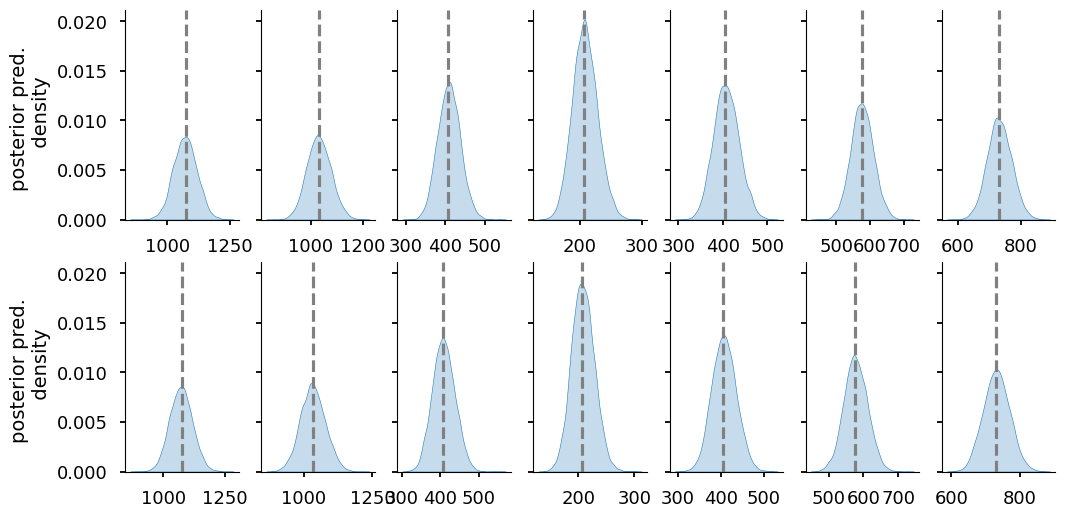

In [14]:
fig, axes = plt.subplots(2, num_precincts, figsize=(12,6), sharey=True)
#THe indexing is a little funny here because we want the ordering
# be alphabetical, but the data is ordered by rows ABCDFEG (not in order)
for i in [0,1,2,3,5,4,6]:
    ax = axes[0][i]
    sns.kdeplot(calls_for_service_posterior_pred_samps[i, :], fill=True, ax=ax)
    ax.set_ylabel('posterior pred. \n density', fontsize=14)
    ax.axvline(C[i], linestyle='--', color='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = axes[1][i]
    sns.kdeplot(calls_for_service_posterior_pred_samps_inc[i, :], fill=True, ax=ax)
    ax.set_ylabel('posterior pred. \n density', fontsize=14)
    ax.axvline(C[i], linestyle='--', color='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig('figs/posterior_predictive_check.png', dpi=300, bbox_inches='tight')

## Convergence diagnostics

In [15]:
az.rhat(sim_trace_model2).max().values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_1     float64 1.001
    mu_2     float64 1.001
    sigma_1  float64 0.9998
    sigma_2  float64 1.002
    b_1      float64 1.003
    b_2      float64 1.003)

In [16]:
az.ess(sim_trace_model2).min().values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_1     float64 4.352e+03
    mu_2     float64 3.258e+03
    sigma_1  float64 8.022e+03
    sigma_2  float64 1.267e+03
    b_1      float64 1.583e+03
    b_2      float64 1.407e+03)

In [17]:
az.rhat(sim_trace_model2_inc).max().values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_1     float64 1.001
    mu_2     float64 1.001
    sigma_1  float64 1.003
    sigma_2  float64 1.0
    b_1      float64 1.003
    b_2      float64 1.002)

In [18]:
az.rhat(sim_trace_model2_inc).min().values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_1     float64 1.001
    mu_2     float64 1.001
    sigma_1  float64 1.003
    sigma_2  float64 1.0
    b_1      float64 1.0
    b_2      float64 1.001)

### Create and save plots

### Block-group level plot

/var/folders/d5/5428vcvx0rx9nfq5d27_n2680000gn/T/ipykernel_40210/636900588.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2')


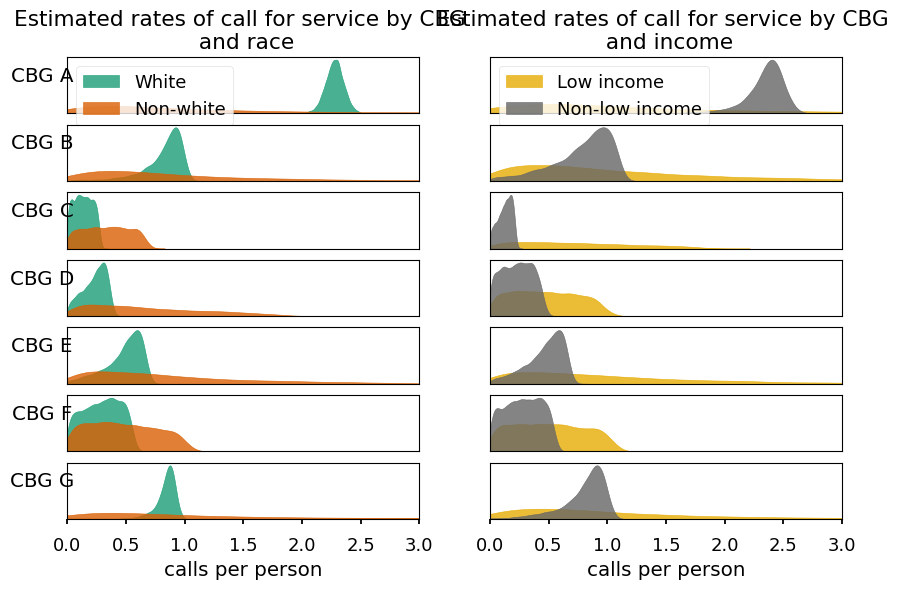

In [19]:
# View estimated call-for-service rates by block group
CBG_letters = ['A', 'B','C', 'D', 'F', 'E', 'G']

cmap = plt.cm.get_cmap('Dark2')
color0 = cmap(0)
color1 = cmap(1)
color2 = cmap(5)
color3 = cmap(7)
kde_alpha=0.8

percentiles = [2.5, 97.5]
b_1 = sim_trace_model2["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values
b_2 = sim_trace_model2["posterior"]["b_2"].stack(all_draws=["chain", "draw"]).values

b_1_inc = sim_trace_model2_inc["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values
b_2_inc = sim_trace_model2_inc["posterior"]["b_2"].stack(all_draws=["chain", "draw"]).values


fig, axes = plt.subplots(num_precincts, 2, figsize=(10,6))

#THe indexing is a little funny here because we want the ordering
# be alphabetical, but the data is ordered by rows ABCDFEG (not in order)
for plot_idx, row_idx in zip([0,1,2,3,4,5,6], [0,1,2,3,5,4,6]):
    ax = axes[plot_idx,0]
    sns.kdeplot(b_1[row_idx],ax=ax, fill=True,label="White", color=color0, alpha=kde_alpha)
    sns.kdeplot(b_2[row_idx],ax=ax, fill=True, label="Non-white",color=color1, alpha=kde_alpha)
    ax.set_xlim((0,3))
    ax.set_ylabel(f"CBG {CBG_letters[row_idx]}",rotation=0, labelpad=18)
    ax.set_yticks([])
    if plot_idx != num_precincts-1:
        ax.set_xticks([])

    
    ax = axes[row_idx,1]
    sns.kdeplot(b_1_inc[plot_idx],ax=ax, fill=True,label="Low income", color=color2, alpha=kde_alpha)
    sns.kdeplot(b_2_inc[plot_idx],ax=ax, fill=True, label="Non-low income",color=color3, alpha=kde_alpha)
    ax.set_xlim((0,3))
    ax.set_yticks([])
    ax.set_ylabel("")


    if plot_idx != num_precincts-1:
        ax.set_xticks([])

axes[6,0].set_xlabel("calls per person")
axes[6,1].set_xlabel("calls per person")
    
axes[0,0].set_title("Estimated rates of call for service by CBG \n and race")
axes[0,1].set_title("Estimated rates of call for service by CBG \n and income")
axes[0,0].legend(loc='upper left')
axes[0,1].legend(loc='upper left')


fig.savefig("CBG_rate_ests.png", bbox_inches='tight')

plt.show()

### Aggregated plot

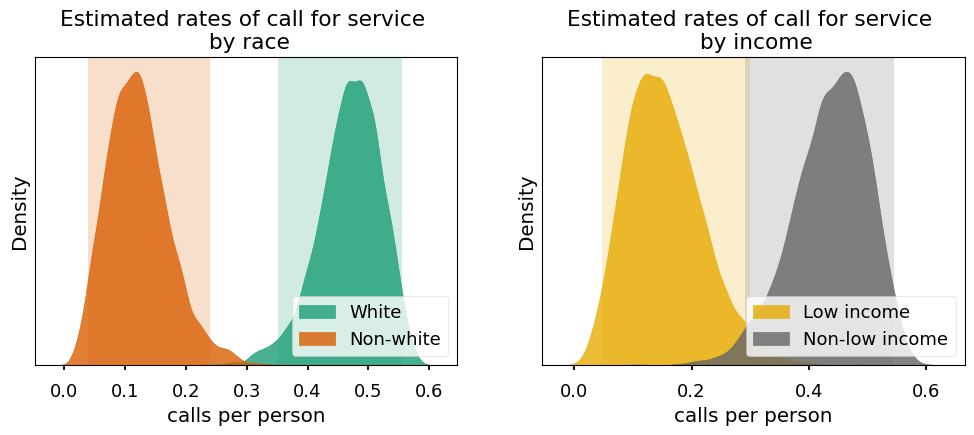

White: 0.46890563868657537, [0.35097796 0.55433355] 
non-White: 0.12142666041002638, [0.0383347  0.23843011] 
Low income: 0.1539898150890677, [0.04683534 0.29832048] 
non-low income: 0.43646319797466276, [0.29199446 0.54463688] 


In [20]:
call_rate_white_aggregated = (b_1.T * num_white ).sum(axis=1) / p.sum() # samples
call_rate_non_white_aggregated = (b_2.T * num_non_white).sum(axis=1) / p.sum() #samples

call_rate_low_inc_aggregated = (b_1_inc.T * num_low_inc ).sum(axis=1) / p.sum() # samples
call_rate_non_low_inc_aggregated = (b_2_inc.T * num_non_low_inc).sum(axis=1) / p.sum() #samples


fig, axes = plt.subplots(1,2, figsize=(12,4))

ax = axes[0]
sns.kdeplot(call_rate_white_aggregated,ax=ax, fill=True,label="White", color=color0, alpha=kde_alpha)
sns.kdeplot(call_rate_non_white_aggregated, ax=ax, fill=True, label="Non-white", color=color1, alpha=kde_alpha)
ax.set_yticks([])
ax.axvspan(np.percentile(call_rate_white_aggregated, percentiles)[0], np.percentile(call_rate_white_aggregated, percentiles)[1], color= color0, alpha = .2, zorder = 0)
ax.axvspan(np.percentile(call_rate_non_white_aggregated, percentiles)[0], np.percentile(call_rate_non_white_aggregated, percentiles)[1], color= color1, alpha = .2, zorder = 0)
ax.set_xlabel("calls per person")

ax.set_title("Estimated rates of call for service \n by race")
ax.legend(loc='lower right')

ax = axes[1]
sns.kdeplot(call_rate_low_inc_aggregated,ax=ax, fill=True,label="Low income", color=color2, alpha=kde_alpha)
sns.kdeplot(call_rate_non_low_inc_aggregated, ax=ax, fill=True, label="Non-low income", color=color3, alpha=kde_alpha)
ax.set_yticks([])
ax.set_title("Estimated rates of call for service \n by income")
ax.legend(loc='lower right')
ax.axvspan(np.percentile(call_rate_low_inc_aggregated, percentiles)[0], np.percentile(call_rate_low_inc_aggregated, percentiles)[1], color= color2, alpha = .2, zorder = 0)
ax.axvspan(np.percentile(call_rate_non_low_inc_aggregated, percentiles)[0], np.percentile(call_rate_non_low_inc_aggregated, percentiles)[1], color= color3, alpha = .2, zorder = 0)
ax.set_xlabel("calls per person")

fig.savefig("Aggregated_rate_ests.png")
plt.show()

print(f"White: {call_rate_white_aggregated.mean()}, {np.percentile(call_rate_white_aggregated, percentiles)} ")
print(f"non-White: {call_rate_non_white_aggregated.mean()}, {np.percentile(call_rate_non_white_aggregated, percentiles)} ")
print(f"Low income: {call_rate_low_inc_aggregated.mean()}, {np.percentile(call_rate_low_inc_aggregated, percentiles)} ")
print(f"non-low income: {call_rate_non_low_inc_aggregated.mean()}, {np.percentile(call_rate_non_low_inc_aggregated, percentiles)} ")



# The Regression Problem
We propose to solve the following regression equation

$$
C_i = r_g \cdot p_i \cdot X_i + r_0 \cdot p_i \cdot (1-X_i)
$$

where $C_i$ is the number of calls for service in CBG$_i$, $p_i$ is the population of CBG$_i$, and $X_i$ is the proportion of residents from demographic group $g$ in CBG $i$. In this model, we are solving the for coefficients $r_g$, the _in-group rate of calls for service_ and $r_0$, the _out-group rate of calls for service_.  Before solving, we will normalize the equation as follows,

$$
\frac{C_i}{p_i\cdot m} =  \frac{r_g}{m} \cdot X_i + \frac{r_0}{m} \cdot (1-X_i)
$$

for a normalizing contstant $m$ defined below.  Then using the tools of PyEi we can solve 

$$
Y_i = \beta^g \cdot X_i + \beta^0 \cdot (1- X_i)
$$
in the usual way, where 

\begin{eqnarray*}
Y_i =  \frac{C_i}{p_i\cdot m}\,\,\,\text{ and }\,\,\,
\beta^g & = & \frac{r_g}{m}\,\,\,\text{ and }\,\,\,
\beta^0 & = & \frac{r_0}{m}.
\end{eqnarray*}


In [21]:
# Number of calls by CBG
C = (np.array(data["tot_count_pre"]) - np.array(data["init_count_pre"])) 
C

array([1074, 1031,  408,  206,  406,  576,  731])

In [22]:
# Number of people by CBG
p = data["pop"].values
p

array([ 478, 1212, 2109,  676, 1137, 1044,  858])

## Analysis by Race

We will first example white and non-white citizen cohorts.

In [23]:
# Proportion of white residents by CBG.
X_race = np.array((data["race_w"]/100))
X_race

array([0.9707, 0.8523, 0.7112, 0.8314, 0.6456, 0.818 , 0.9266])

In [24]:
# Number of white residents by CBG.
num_white = X_race * data["pop"].values
num_white

array([ 463.9946, 1032.9876, 1499.9208,  562.0264,  734.0472,  853.992 ,
        795.0228])

In [25]:
# Proportion of non-white residents by CBG.
1-X_race

array([0.0293, 0.1477, 0.2888, 0.1686, 0.3544, 0.182 , 0.0734])

In [26]:
# Number of non-white residents by CBG.
num_non_white = (1-X_race)*data["pop"].values
num_non_white

array([ 14.0054, 179.0124, 609.0792, 113.9736, 402.9528, 190.008 ,
        62.9772])

In [27]:
# # Normalizing Constant
max_calls = max(C)
min_pop = min(np.concatenate([num_white, num_non_white]))
m_race = max_calls / min_pop
m_race

76.68470732717353

In [28]:
# Normalized call rate by CBG
Y_race = (m_race ** -1) * np.array(C / data["pop"])
Y_race

array([0.0293    , 0.01109296, 0.00252275, 0.00397385, 0.00465647,
       0.00719471, 0.01111019])

In [29]:
demographic_group_name = "white"
demographic_group_name 

'white'

In [30]:
precinct_pops = np.array(data["pop"])
demographic_group_name = "white"
candidate_name = "Calls for Service"
precinct_names = list(data.index)

In [31]:
df_race = pd.DataFrame()
df_race["Percentage white"] = X_race
df_race["Call for service rate"] = Y_race

In [32]:
#Fitting a first 2 x 2 model

#Create a TwobyTwoEI object
ei_race = pyei.TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=15, pareto_shape=2)

# Fit the model
ei_race.fit(group_fraction = X_race, 
       votes_fraction = Y_race, 
       precinct_pops = precinct_pops, 
       demographic_group_name=demographic_group_name , 
       candidate_name=candidate_name, 
       precinct_names=precinct_names, 
       draws=1200, # optional
       tune=3000, # optional
       target_accept=.99, # optional,
       random_seed=614
)

# Generate a simple report to summarize the results
print(ei_race.summary())

Compiling...


/Users/karin/miniconda3/envs/police/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/karin/miniconda3/envs/police/lib/python3.11/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:01.212512
Sampling...


Compiling.. :   0%|          | 0/4200 [00:00<?, ?it/s]







Running chain 0:   0%|          | 0/4200 [00:02<?, ?it/s]


Running chain 0:  10%|█         | 420/4200 [00:02<00:01, 2964.34it/s]





Running chain 0:  15%|█▌        | 630/4200 [00:02<00:02, 1387.59it/s]





Running chain 0:  20%|██        | 840/4200 [00:02<00:03, 1036.05it/s]

Running chain 0:  30%|███       | 1260/4200 [00:02<00:01, 1574.53it/s]




Running chain 0:  40%|████      | 1680/4200 [00:03<00:01, 1756.06it/s]


Running chain 0:  60%|██████    | 2520/4200 [00:03<00:00, 2521.75it/s]

Running chain 3: 100%|██████████| 4200/4200 [00:04<00:00, 926.71it/s] 


Sampling time =  0:00:04.873366
Transforming variables...
Transformation time =  0:00:00.050005
Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        white for Calls for Service is
        0.006
        The posterior mean for the district-level voting preference of
        non-white for Calls for Service is
        0.018
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        white for Calls for Service is
        [0.00169187 0.01013624]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-white for Calls for Service is
        [5.69549679e-05 4.47010059e-02]
        


In [33]:
means = np.array(ei_race.posterior_mean_voting_prefs) * m_race
cred_int = np.array(ei_race.credible_interval_95_mean_voting_prefs) * m_race

m = np.around(means[0], decimals = 2)
c = [np.around(i, decimals = 2) for i in cred_int[0]]
print(f"The posterior mean belief for white is {m} with 95% credible interval {c}.")

m = np.around(means[1], decimals = 2)
c = [np.around(i, decimals = 2) for i in cred_int[1]]
print("")
print(f"The posterior mean belief for non-white is {m} with 95% credible interval {c}.")

The posterior mean belief for white is 0.44 with 95% credible interval [0.13, 0.78].

The posterior mean belief for non-white is 1.37 with 95% credible interval [0.0, 3.43].


In [34]:
# Fitting Goodman's ER - precincts weighted by population
race_goodmans_er = pyei.GoodmansER(is_weighted_regression="True")

race_goodmans_er.fit(group_fraction = X_race, 
    vote_fraction = Y_race,
    precinct_pops = precinct_pops, # Must include populations if weighting by population
    demographic_group_name=demographic_group_name, 
    candidate_name=candidate_name
)

print(race_goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of white
        voters who voted for Calls for Service is
        0.018
        Est. fraction of non- white
        voters who voted for Calls for Service is
        -0.032
        


In [35]:
race_slope = m_race * float(race_goodmans_er.slope_)
race_intercept = m_race * float(race_goodmans_er.intercept_)

race_slope

3.842159456433298

In [36]:
X_race

array([0.9707, 0.8523, 0.7112, 0.8314, 0.6456, 0.818 , 0.9266])

In [37]:
Y_race

array([0.0293    , 0.01109296, 0.00252275, 0.00397385, 0.00465647,
       0.00719471, 0.01111019])

In [38]:
# NOTE: we've modified the source code here to set the prior distribution of the call rates b_1 to uniform (0,10)
bayes_goodman_ei = pyei.GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)

bayes_goodman_ei.fit(
    group_fraction = X_race, 
    votes_fraction = Y_race,
    precinct_pops = precinct_pops,
    demographic_group_name=demographic_group_name, 
    candidate_name=candidate_name,
    random_seed=614,
    tune=2000,
    target_accept=0.995,
)

print(bayes_goodman_ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/karin/miniconda3/envs/police/lib/python3.11/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_1, b_2, eps]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


Model: goodman_er_bayes
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        white for Calls for Service is
        0.008
        The posterior mean for the district-level voting preference of
        non-white for Calls for Service is
        0.012
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        white for Calls for Service is
        [0.00068052 0.01824683]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-white for Calls for Service is
        [0.00022292 0.04537361]
        


In [39]:
print(f'max rhat {(az.rhat(bayes_goodman_ei.sim_trace).max())}')
print(f'min ess {az.ess(bayes_goodman_ei.sim_trace).max()}')

max rhat <xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.001
    b_2      float64 1.002
    eps      float64 1.002
min ess <xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.746e+03
    b_2      float64 1.729e+03
    eps      float64 2.28e+03


In [40]:
#ei_race.plot_kde()

In [41]:
#ei_race.plot_polarization_kde(percentile=95, show_threshold=True)

## Analysis by Income Level

They do, however, have the ratio of income to poverty level. Many programs use income as a percent of poverty level as a threshold, like 130% for SNAP and 200% for others like prioritized childcare, so I included the percent of people living above 200% (`incpov_2_`) and below 200% (`incpov__2`). Note that the number of people for whom this data is available is a lot lower than the total number of people in the CBGS for the school (the attached Excel sheet has the raw data on these), so it might not capture the entire population. I’ve also included the per capita income (`incpercap`) from the Census, should you decide to use that instead. The federal poverty line is evidently outdated, and many programs and states now use a relative % of median income for the state/area, but I haven’t found that data from the Census.  

In [42]:
data.head()

,GEOID10,pop,race_w,race_b,hhinc,incpercap,incpov_2_,incpov__2,init_count_pre,init_day_pre,tot_count_pre,tot_day_pre,init_p_pre,init_count_covid,init_day_covid,tot_count_covid,tot_day_covid,init_p_covid
0,250039201011,478,97.07,0.00,83667,73312,90.17,9.83,2815,7.019950,3889,9.698254,72.383646,482,2.190909,945,4.295455,51.005291
1,250039201012,1212,85.23,4.04,77604,42620,77.56,22.44,2161,5.389027,3192,7.960100,67.700501,782,3.554545,1373,6.240909,56.955572
2,250039201013,2109,71.12,7.02,105913,21587,89.16,10.84,1524,3.800499,1932,4.817955,78.881988,63,0.286364,231,1.050000,27.272727
3,250039201014,676,83.14,0.00,66944,35319,68.20,31.80,174,0.433915,380,0.947631,45.789474,14,0.063636,79,0.359091,17.721519
4,250039201021,1137,64.56,9.59,55167,14173,65.80,34.20,555,1.384040,961,2.396509,57.752341,12,0.054545,207,0.940909,5.797101


In [43]:
# Proportion of non low income residents by CBG.
X_pov = 1 - np.array((data["incpov__2"]/100))
X_pov

array([0.9017, 0.7756, 0.8916, 0.682 , 0.658 , 0.8238, 0.8505])

In [44]:
# Number of non-low income residents by CBG.
num_non_low_inc = X_pov*data["pop"].values
num_non_low_inc

array([ 431.0126,  940.0272, 1880.3844,  461.032 ,  748.146 ,  860.0472,
        729.729 ])

In [45]:
# Proportion of low income residents by CBG.
1-X_pov

array([0.0983, 0.2244, 0.1084, 0.318 , 0.342 , 0.1762, 0.1495])

In [46]:
# Number of non low-income residents by CBG.
num_low_inc = (1-X_pov)*data["pop"].values
num_low_inc

array([ 46.9874, 271.9728, 228.6156, 214.968 , 388.854 , 183.9528,
       128.271 ])

In [47]:
# # Normalizing Constant
# total_lowinc_people = np.array((data["incpov__2"]/100)) * np.array(data["pop"])
# total_calls = (np.array(data["tot_count_pre"]) - np.array(data["init_count_pre"])) 
# m_pov = max(total_calls /total_lowinc_people)
# m_pov

In [48]:
# # Normalizing Constant 
max_calls = max(C)
min_pop = min(np.concatenate([num_low_inc, num_non_low_inc]))
m_pov = max_calls / min_pop
m_pov

22.857191502402785

In [49]:
# Normalized call rate by CBG
Y_pov = (m_pov ** -1) * np.array(C / data["pop"])
Y_pov

array([0.0983    , 0.0372163 , 0.00846371, 0.01333207, 0.01562222,
       0.02413788, 0.0372741 ])

In [50]:
df_pov = pd.DataFrame()
df_pov["Percentage non low income"] = X_pov
df_pov["Call for service rate"] = Y_pov

In [51]:
demographic_group_name = "high/middle income"
demographic_group_name 

'high/middle income'

In [52]:
precinct_pops = np.array(data["pop"])
demographic_group_name = "high/middle income"
candidate_name = "Calls for Service"
precinct_names = list(data.index)

In [53]:
Fitting a first 2 x 2 model

# Create a TwobyTwoEI object
ei_pov = pyei.TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=15, pareto_shape=2)

# Fit the model
ei_pov.fit(group_fraction = X_pov, 
       votes_fraction = Y_pov, 
       precinct_pops = precinct_pops, 
       demographic_group_name=demographic_group_name, 
       candidate_name=candidate_name, 
       precinct_names=precinct_names, 
       draws=1200, # optional
       tune=3000, # optional
       target_accept=.99,# optional,
       random_seed=614
)

# Generate a simple report to summarize the results
print(ei_pov.summary())

SyntaxError: invalid syntax (3777656339.py, line 1)

In [ ]:
means = np.array(ei_pov.posterior_mean_voting_prefs) * m_pov
cred_int = np.array(ei_pov.credible_interval_95_mean_voting_prefs) * m_pov

m = np.around(means[0], decimals = 2)
c = [np.around(i, decimals = 2) for i in cred_int[0]]
print(f"The posterior mean belief for high/middle-income is {m} with 95% credible interval {c}.")

m = np.around(means[1], decimals = 2)
c = [np.around(i, decimals = 2) for i in cred_int[1]]
print("")
print(f"The posterior mean belief for low-income is {m} with 95% credible interval {c}.")

In [ ]:
# Fitting Goodman's ER - precincts weighted by population
pov_goodmans_er = pyei.GoodmansER(is_weighted_regression="True")

pov_goodmans_er.fit(group_fraction = X_pov, 
    vote_fraction = Y_pov,
    precinct_pops = precinct_pops, # Must include populations if weighting by population
    demographic_group_name=demographic_group_name, 
    candidate_name=candidate_name
)

print(pov_goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of high/middle income
        voters who voted for Calls for Service is
        0.036
        Est. fraction of non- high/middle income
        voters who voted for Calls for Service is
        -0.015
        


In [ ]:
bayes_goodman_ei_pov = pyei.GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)

bayes_goodman_ei_pov.fit(
    group_fraction = X_pov, 
    votes_fraction = Y_pov,
    precinct_pops = precinct_pops,
    demographic_group_name=demographic_group_name, 
    candidate_name=candidate_name,
    tune=2000,
    target_accept=0.995, 
    random_seed=614,
)

bayes_goodman_ei_pov.summary()

print(f'max rhat {(az.rhat(bayes_goodman_ei.sim_trace).max())}')
print(f'min ess {az.ess(bayes_goodman_ei.sim_trace).max()}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/karin/miniconda3/envs/police/lib/python3.11/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_1, b_2, eps]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.


max rhat <xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.002
    b_2      float64 1.001
    eps      float64 1.001
min ess <xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.744e+03
    b_2      float64 1.888e+03
    eps      float64 2.499e+03


[0.46, 1.26]
[0.16 0.77]
[0.03 3.2 ]

[0.48, 1.04]
[0.15 0.76]
[0.   2.55]


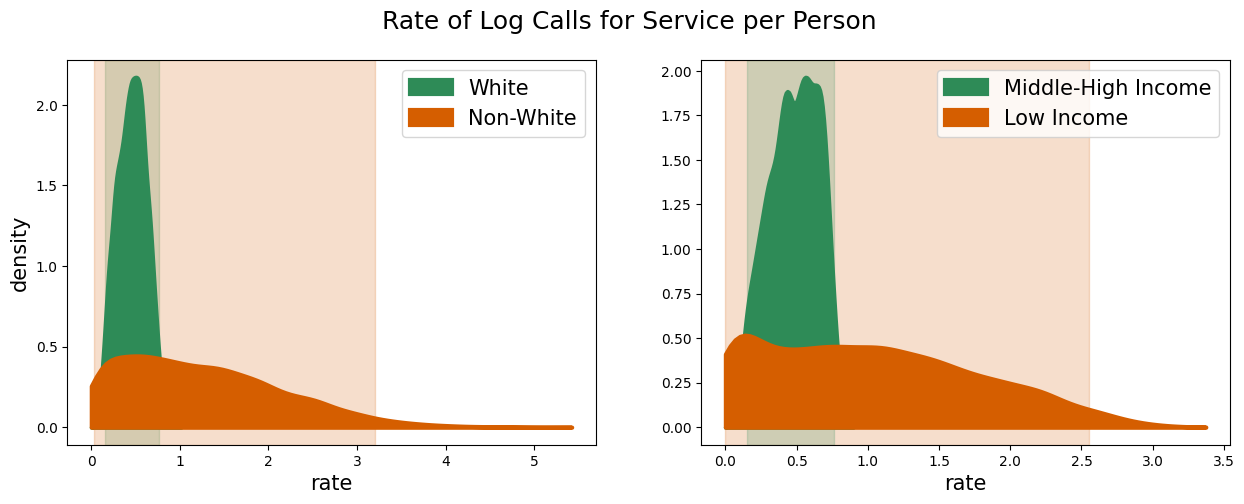

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

COLOR_MAP = {
    "light_orange": "#E69F00",
    "light_blue": "#56B4E9",
    "teal": "#009E73",
    "yellow": "#F0E442",
    "dark_blue": "#0072B2",
    "dark_orange": "#D55E00",
    "pink": "#CC79A7",
    "purple": "#9370DB",
    "black": "#000000",
    "silver": "#DCDCDC",
}
names = list(ei_race.group_names_for_display())
fig, ax = plt.subplots(1, 2, figsize = (15,5))

# Race
val_white = m_race * ei_race._voting_prefs_array()[:,0,0]
val_nonwhite = m_race * ei_race._voting_prefs_array()[:,1,0]
nonwhite_color = COLOR_MAP["dark_orange"]
white_color = "seagreen"
conf_white = np.percentile(val_white, [2.5, 97.5])
conf_nonwhite = np.percentile(val_nonwhite, [2.5, 97.5])
print([np.around(m * m_race, decimals = 2) for m in ei_race.posterior_mean_voting_prefs])
print(np.around(conf_white, decimals = 2))
print(np.around(conf_nonwhite, decimals = 2))

kde = stats.gaussian_kde(val_white)
tt = np.linspace(0, val_white.max(), 100)
#ax[0].hist(val_white, bins = 20, linewidth = 1, density = True, color = white_color, alpha = .4)
x = tt
y = kde(tt)
#x = x[np.where(kde(tt) > 1e-08)[0]]
#y = y[np.where(kde(tt) > 1e-08)[0]]
ax[0].fill_between(x, y, linewidth = 3, label = "White", color = white_color)

kde = stats.gaussian_kde(val_nonwhite)
tt = np.linspace(0, val_nonwhite.max(), 100)
#ax[0].hist(val_nonwhite, bins = 20, linewidth = 1, density = True,color = nonwhite_color, alpha = .4)

x = tt
y = kde(tt)
x = x[np.where(kde(tt) > 1e-08)[0]]
y = y[np.where(kde(tt) > 1e-08)[0]]
ax[0].fill_between(tt, kde(tt), linewidth = 3, label = "Non-White", color = nonwhite_color)
ax[0].set_xlabel("rate",  fontsize = 15)
ax[0].set_ylabel("density",  fontsize = 15)
ax[0].axvspan(conf_white[0],conf_white[1], color = white_color, alpha = .2, zorder =0)
ax[0].axvspan(conf_nonwhite[0],conf_nonwhite[1], color = nonwhite_color, alpha = .2, zorder = 0)
ax[0].legend(fontsize = 15)
#ax[0].set_ylim(0,14)
#ax[0].set_xlim(0,1)

# Wealth
val_wealth = m_pov * ei_pov._voting_prefs_array()[:,0,0]
val_pov = m_pov * ei_pov._voting_prefs_array()[:,1,0]
pov_color = COLOR_MAP["dark_orange"]
wealth_color = "seagreen"
conf_pov = np.percentile(val_pov, [2.5, 97.5])
conf_wealth = np.percentile(val_wealth, [2.5, 97.5])
print("")
print([np.around(m * m_pov, decimals = 2) for m in ei_pov.posterior_mean_voting_prefs])
print(np.around(conf_wealth, decimals = 2))
print(np.around(conf_pov, decimals = 2))

kde = stats.gaussian_kde(val_wealth)
tt = np.linspace(0, val_wealth.max(), 100)
#ax[1].hist(val_wealth, bins = 20, linewidth = 1, density = True,color = wealth_color, alpha = .4)

x = tt
y = kde(tt)
x = x[np.where(kde(tt) > 1e-08)[0]]
y = y[np.where(kde(tt) > 1e-08)[0]]
ax[1].fill_between(x, y, linewidth = 3, label = "Middle-High Income", color = wealth_color)

kde = stats.gaussian_kde(val_pov)
tt = np.linspace(0, val_pov.max(), 100)
#ax[1].hist(val_pov, bins = 20, linewidth = 2, density = True,color = pov_color, alpha = .4)

x = tt
y = kde(tt)
x = x[np.where(kde(tt) > 1e-08)[0]]
y = y[np.where(kde(tt) > 1e-08)[0]]
ax[1].fill_between(tt, kde(tt), linewidth = 3, label = "Low Income", color = pov_color)
ax[1].set_xlabel("rate", fontsize = 15)
ax[1].axvspan(conf_pov[0],conf_pov[1], color = pov_color, alpha = .2, zorder = 0)
ax[1].axvspan(conf_wealth[0],conf_wealth[1], color = wealth_color, alpha = .2, zorder = 0)
ax[1].legend(fontsize = 15)


plt.suptitle("Rate of Log Calls for Service per Person", fontsize = 18)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

0.5509958070093299
0.056002670318765935


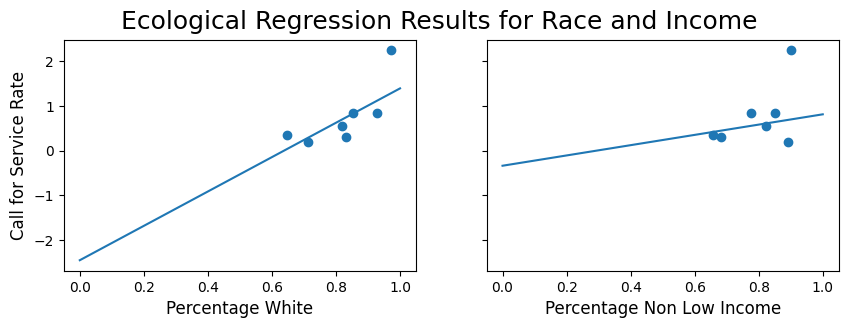

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,3), sharex = True, sharey = True)
race_slope = m_race * race_goodmans_er.slope_
race_intercept = m_race * race_goodmans_er.intercept_
c_true = C/p
c_fit_race = (race_slope * X_race + race_intercept)

ax[0].scatter(X_race,c_true)

print(r2_score(c_true, c_fit_race))
ax[0].plot([0,1],[race_intercept, race_slope[0] + race_intercept])
ax[0].set_ylabel("Call for Service Rate", fontsize = 12)
ax[0].set_xlabel("Percentage White", fontsize = 12)

pov_slope = m_pov * pov_goodmans_er.slope_
pov_intercept = m_pov * pov_goodmans_er.intercept_
c_fit_pov = pov_slope * X_pov + pov_intercept
ax[1].scatter(X_pov, c_true)
print(r2_score(c_true, c_fit_pov))
ax[1].plot([0,1],[pov_intercept, pov_slope[0] + pov_intercept])
ax[1].set_xlabel("Percentage Non Low Income", fontsize = 12)
plt.suptitle("Ecological Regression Results for Race and Income", fontsize = 18)
plt.show()

-0.08862907271526654
-77.27734957807998


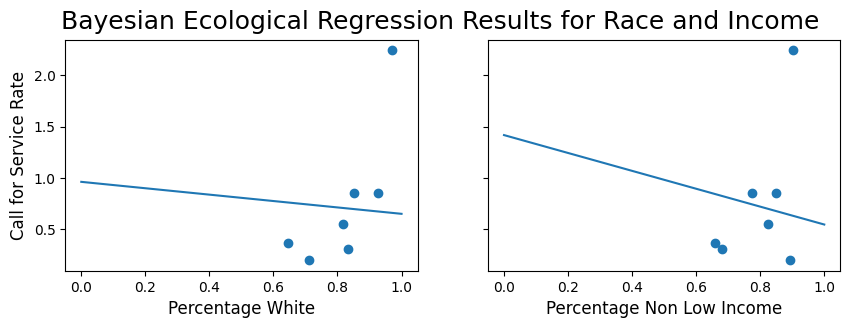

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,3), sharex = True, sharey = True)

slope_samples = az.extract(bayes_goodman_ei.sim_trace)['b_1'].to_numpy() - az.extract(bayes_goodman_ei.sim_trace)['b_2'].to_numpy()
intercept_samples = az.extract(bayes_goodman_ei.sim_trace)['b_2'].to_numpy()

race_slope_b = m_race * slope_samples.mean()
race_intercept_b = m_race * intercept_samples.mean()
c_fit_race = (race_slope_b * X_race + race_intercept_b)

ax[0].scatter(X_race,Y_race * m_race)
print(r2_score(c_true, c_fit_race))
ax[0].plot([0,1],[race_intercept_b, race_slope_b + race_intercept_b])
ax[0].set_ylabel("Call for Service Rate", fontsize = 12)
ax[0].set_xlabel("Percentage White", fontsize = 12)

slope_samples_pov = az.extract(bayes_goodman_ei_pov.sim_trace)['b_1'].to_numpy() - az.extract(bayes_goodman_ei_pov.sim_trace)['b_2'].to_numpy()
intercept_samples_pov = az.extract(bayes_goodman_ei_pov.sim_trace)['b_2'].to_numpy()

pov_slope_b = m_pov * slope_samples_pov.mean()
pov_intercept_b = m_pov * intercept_samples_pov.mean()
c_fit_pov = (pov_slope_b * X_pov + pov_intercept_b)

ax[1].scatter(X_pov,c_true)
print(r2_score(c_fit_pov, c_true))
ax[1].plot([0,1],[pov_intercept_b, pov_slope_b + pov_intercept_b])
ax[1].set_xlabel("Percentage Non Low Income", fontsize = 12)

plt.suptitle("Bayesian Ecological Regression Results for Race and Income", fontsize = 18)
plt.show()

In [ ]:
((1/len(c_true))*((c_fit_race - c_true) ** 2)).sum() ** (1/2)

0.43582363981662225

In [ ]:
(((c_fit_race - c_true) ** 2).sum()/len(c_true)) ** (1/2)

0.43582363981662225

In [ ]:
(((c_fit_pov - c_true) ** 2).sum()/len(c_true)) ** (1/2)

0.6319329023153173

In [ ]:
[np.around(m * m_pov, decimals = 2) for m in ei_pov.posterior_mean_voting_prefs]

[0.46, 1.12]

In [ ]:
race_intercept

-2.4485065807233606

## Linear Regression Analysis with Confidence Intervals

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
alpha = 0.05 # for 95% confidence interval; use 0.01 for 99%-CI.

X = pd.DataFrame(df_race["Percentage white"])
y = df_race["Call for service rate"]

# fit a sklearn LinearRegression model
lin_model = LinearRegression().fit(X, y, sample_weight = precinct_pops)

# the coefficients of the regression model
coefs = np.r_[[lin_model.intercept_], lin_model.coef_]
# build an auxiliary dataframe with the constant term in it
X_aux = X.copy()
X_aux.insert(0, 'const', 1)

# degrees of freedom
dof = -np.diff(X_aux.shape)[0]
# Student's t-distribution table lookup
t_val = stats.t.isf(alpha/2, dof)

# MSE of the residuals
mse = np.sum((y - lin_model.predict(X)) ** 2) / dof

# inverse of the variance of the parameters
var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))

# distance between lower and upper bound of CI
gap = t_val * np.sqrt(mse * var_params)

conf_int = pd.DataFrame({'lower': coefs - gap, 'upper': coefs + gap}, index=X_aux.columns) * m_race
display(conf_int)

,lower,upper
const,-6.396506,1.499493
Percentage white,-0.920438,8.604757


In [ ]:
r_0 = (coefs * m_race)[0]
r_g = (coefs * m_race)[1] + r_0

conf_race = pd.DataFrame(index = ["r_0","r_g", "slope"])
conf_race.loc["r_0","value"] = r_0 
conf_race.loc["r_g","value"] = r_g 
conf_race.loc["slope","value"] = r_g - r_0 

conf_race.loc["r_0","lower"] = conf_int.loc["const","lower"]
conf_race.loc["r_0","upper"] = conf_int.loc["const","upper"]
conf_race.loc["slope","lower"] = conf_int.loc["Percentage white","lower"]
conf_race.loc["slope","upper"] = conf_int.loc["Percentage white","upper"]
conf_race.loc["r_g","lower"] = conf_race.loc["slope","lower"] + conf_race.loc["r_0","lower"]
conf_race.loc["r_g","upper"] = conf_race.loc["slope","upper"] + conf_race.loc["r_0","upper"]
conf_race

,value,lower,upper
r_0,-2.448507,-6.396506,1.499493
r_g,1.393653,-7.316944,10.104250
slope,3.842159,-0.920438,8.604757


In [ ]:
alpha = 0.05 # for 95% confidence interval; use 0.01 for 99%-CI.

X = pd.DataFrame(df_pov["Percentage non low income"])
y = df_pov["Call for service rate"]

# fit a sklearn LinearRegression model
lin_model = LinearRegression().fit(X, y, sample_weight = precinct_pops)

# the coefficients of the regression model
coefs = np.r_[[lin_model.intercept_], lin_model.coef_]
# build an auxiliary dataframe with the constant term in it
X_aux = X.copy()
X_aux.insert(0, 'const', 1)

# degrees of freedom
dof = -np.diff(X_aux.shape)[0]
# Student's t-distribution table lookup
t_val = stats.t.isf(alpha/2, dof)

# MSE of the residuals
mse = np.sum((y - lin_model.predict(X)) ** 2) / dof

# inverse of the variance of the parameters
var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))

# distance between lower and upper bound of CI
gap = t_val * np.sqrt(mse * var_params)

conf_int = pd.DataFrame({'lower': coefs - gap, 'upper': coefs + gap}, index=X_aux.columns) * m_pov
conf_int

,lower,upper
const,-6.826593,6.15479
Percentage non low income,-6.936971,9.23632


In [ ]:
r_0 = (coefs * m_pov)[0]
r_g = (coefs * m_pov)[1] + r_0

conf_race = pd.DataFrame(index = ["r_0","r_g", "slope"])
conf_race.loc["r_0","value"] = r_0 
conf_race.loc["r_g","value"] = r_g 
conf_race.loc["slope","value"] = r_g - r_0 

conf_race.loc["r_0","lower"] = conf_int.loc["const","lower"]
conf_race.loc["r_0","upper"] = conf_int.loc["const","upper"]
conf_race.loc["slope","lower"] = conf_int.loc["Percentage non low income","lower"]
conf_race.loc["slope","upper"] = conf_int.loc["Percentage non low income","upper"]
conf_race.loc["r_g","lower"] = conf_race.loc["slope","lower"] + conf_race.loc["r_0","lower"]
conf_race.loc["r_g","upper"] = conf_race.loc["slope","upper"] + conf_race.loc["r_0","upper"]
conf_race

,value,lower,upper
r_0,-0.335902,-6.826593,6.15479
r_g,0.813773,-13.763564,15.39111
slope,1.149675,-6.936971,9.23632


In [ ]:
y = df_race["Call for service rate"]

In [ ]:
mean_precinct_pop = precinct_pops.mean()
with pm.Model() as bayes_er_model:
    b_1 = pm.Uniform("b_1", 0, 10)
    b_2 = pm.Uniform("b_2", 0, 10)

    eps = pm.HalfNormal("eps", sigma=sigma)

    pm.Normal(
        "votes_count_obs",
        b_2 + (b_1 - b_2) * group_fraction,
        sigma=eps * pm.math.sqrt(mean_precinct_pop / precinct_pops),
        observed=votes_fraction,
    )

return bayes_er_model